# Leaf Classification : Kaggle Competition
**By Sim, Lee, Cho**

|  <h1> Purpose & Input </h1> |  <h1> Output & Result </h1>       |
| :-----                      | :-----                   |
| <h2> Leaf Species Prediction(99 categories) </h2>      |    <h2> Categorical Probability </h2>     |
| <h2> Leaf df & img data </h2>                          |    <h2> score : log loss </h2>     |


<img src="https://i.stack.imgur.com/NEmt7.png"/>

       

![alt text](graph1.png "graph")

![alt text](model.png "model")

# * Environment Setting

In [4]:
# pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

# * Importing Part

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

######################################  Preprocessing,PCA  ######################################

from skimage.transform import rescale
from scipy import ndimage as ndi
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

######################################  Image contol  ######################################
import cv2
from scipy.spatial import distance

######################################  Model & Optimization  ######################################
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, log_loss
from sklearn.model_selection import cross_val_score, GridSearchCV

# * Function Moduling Part

In [2]:
# encogin categorical values for further processing
def encode_cat(df):
    """
       Input : train_df 
       Output : encoded_train_df
    """
    # get categorical(type='object') variable
    cat_var_df = df.select_dtypes(include=['object']).copy()    
    
    cleanup_nums = {}
    
    # species columns encoding
    spe_index = 0
    spe_enc_dict = {}
    for key in set(cat_var_df['species'].values):
        spe_enc_dict[key] = spe_index
        spe_index += 1
    cleanup_nums['species'] = spe_enc_dict
    
    try:
        cat_var_df.replace(cleanup_nums, inplace=True)
    except:
        raise ValueError("Please check your input df")
    
    df = df.drop(cat_var_df.columns, axis=1)
    df = pd.concat([df, cat_var_df], axis=1)
    return df

# * Data handling Part

In [118]:
train_df = pd.read_csv("../train.csv")
test_df = pd.read_csv("../test.csv")
# train_df_id = train_df['id'].values
# test_df_id = test_df['id'].values

# encoded('species') version of train_df
train_df_enc = encode_cat(train_df)
dfX = train_df_enc.drop(['id', 'species'], axis=1).copy()
dfy = train_df_enc.loc[:, 'species'].copy()
dfy_onehot = label_binarize(dfy, classes=range(99)).copy()

dfX_test = test_df.drop(['id'], axis=1).copy()

# dfX scaled, standardized
dfX_minmax_scaled = pd.DataFrame(MinMaxScaler().fit_transform(dfX), columns=dfX.columns).copy()
dfX_std_scaled = pd.DataFrame(StandardScaler().fit_transform(dfX), columns=dfX.columns).copy()
dfX_test_minmax_scaled = pd.DataFrame(MinMaxScaler().fit_transform(dfX_test), columns=dfX_test.columns).copy()
dfX_test_std_scaled =pd.DataFrame(StandardScaler().fit_transform(dfX_test), columns=dfX_test.columns).copy()

# added 3-area factors(aspect_ratio, extent, solidity) on dfX standardized
area_3_factors_df = pd.read_csv('../3area_factors_20171113.csv')
area_3_factors_scaled_df = pd.DataFrame(StandardScaler().fit_transform(area_3_factors_df), columns=area_3_factors_df.columns).copy()

dfX_std_scaled_id = pd.concat([dfX_std_scaled, train_df['id']], axis=1).copy()
dfX_std_scaled_id['id'] = dfX_std_scaled_id['id'] - 1
dfX_std_scaled_3area = pd.merge(dfX_std_scaled_id, area_3_factors_scaled_df, left_on='id', right_index=True, how='left').copy().drop(['id'], axis=1)

dfX_test_std_scaled_id = pd.concat([dfX_test_std_scaled, test_df['id']], axis=1).copy()
dfX_test_std_scaled_id['id'] = dfX_test_std_scaled_id['id'] - 1
dfX_test_std_scaled_3area = pd.merge(dfX_test_std_scaled_id, area_3_factors_scaled_df, \
                                     left_on='id', right_index=True, how='left').copy().drop(['id'], axis=1)

# added original pixel rows, cols
pixel_rows_cols_df = pd.read_csv("../pixel_rows_cols_df_20171107.csv")
pixel_rows_cols_scaled_df = pd.DataFrame(StandardScaler().fit_transform(pixel_rows_cols_df), columns=pixel_rows_cols_df.columns).copy()

dfX_std_scaled_3area_id = pd.concat([dfX_std_scaled_3area, train_df['id']], axis=1).copy()
dfX_std_scaled_3area_id['id'] = dfX_std_scaled_3area_id['id'] - 1
dfX_std_scaled_3area_rc = pd.merge(dfX_std_scaled_3area_id, pixel_rows_cols_scaled_df, \
                                   left_on='id', right_index=True, how='left').copy().drop(['id'], axis=1)

dfX_test_std_scaled_3area_id = pd.concat([dfX_test_std_scaled_3area, test_df['id']], axis=1).copy()
dfX_test_std_scaled_3area_id['id'] = dfX_test_std_scaled_3area_id['id'] - 1
dfX_test_std_scaled_3area_rc = pd.merge(dfX_test_std_scaled_3area_id, pixel_rows_cols_scaled_df, \
                                     left_on='id', right_index=True, how='left').copy().drop(['id'], axis=1)

# added PCA results
pca_df = pd.read_csv('../pca_df.csv')
pca_scaled_df = pd.DataFrame(StandardScaler().fit_transform(pca_df), columns=pca_df.columns)

dfX_std_scaled_3area_rc_id = pd.concat([dfX_std_scaled_3area_rc, train_df['id']], axis=1).copy()
dfX_std_scaled_3area_rc_id['id'] = dfX_std_scaled_3area_rc_id['id'] - 1
dfX_std_scaled_3area_rc_pca = pd.merge(dfX_std_scaled_3area_rc_id, pca_scaled_df, \
                                   left_on='id', right_index=True, how='left').copy().drop(['id'], axis=1)

dfX_test_std_scaled_3area_rc_id = pd.concat([dfX_test_std_scaled_3area_rc, test_df['id']], axis=1).copy()
dfX_test_std_scaled_3area_rc_id['id'] = dfX_test_std_scaled_3area_rc_id['id'] - 1
dfX_test_std_scaled_3area_rc_pca = pd.merge(dfX_test_std_scaled_3area_rc_id, pca_scaled_df, \
                                     left_on='id', right_index=True, how='left').copy().drop(['id'], axis=1)

# train, test processed csv
train_processed_df = pd.concat([dfX_std_scaled_3area_rc_pca, train_df['id'], dfy], axis=1).copy()
test_processed_df = pd.concat([dfX_test_std_scaled_3area_rc_pca, test_df['id']], axis=1).copy()

# train_processed_df.to_csv('../train_processed_df_20171121.csv', index=False)
# test_processed_df.to_csv('../test_processed_df_20171121.csv', index=False)

In [117]:
print(dfX_std_scaled.shape)
print(dfX_test_std_scaled.shape)

print(dfX_std_scaled_3area.shape)
print(dfX_test_std_scaled_3area.shape)

print(dfX_std_scaled_3area_rc.shape)
print(dfX_test_std_scaled_3area_rc.shape)

print(dfX_std_scaled_3area_rc_pca.shape)
print(dfX_test_std_scaled_3area_rc_pca.shape)

print(train_processed_df.shape)
print(test_processed_df.shape)

(990, 192)
(594, 192)
(990, 195)
(594, 195)
(990, 197)
(594, 197)
(990, 247)
(594, 247)
(990, 249)
(594, 248)


#   
# 1. EDA & Preprocessing
- 1.1 Data EDA
- 1.2 Feature Extraction from img

## 1.1 Data EDA

In [7]:
print("train_df    :", train_df.shape)
print("test_df     :", test_df.shape)
print("y category  :", len(train_df['species'].unique()))
print("dfX         :", dfX.shape)
print("dfy         :", dfy.shape)

train_df    : (990, 194)
test_df     : (594, 193)
y category  : 99
dfX         : (990, 192)
dfy         : (990,)


In [8]:
train_df.tail()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
985,1575,Magnolia_Salicifolia,0.060547,0.119140,0.007812,0.003906,0.000000,0.148440,0.017578,0.0,...,0.242190,0.000000,0.034180,0.000000,0.010742,0.000000,0.000000,0.000000,0.000000,0.018555
986,1578,Acer_Pictum,0.001953,0.003906,0.021484,0.107420,0.001953,0.000000,0.000000,0.0,...,0.170900,0.000000,0.018555,0.000000,0.011719,0.000000,0.000000,0.000977,0.000000,0.021484
987,1581,Alnus_Maximowiczii,0.001953,0.003906,0.000000,0.021484,0.078125,0.003906,0.007812,0.0,...,0.004883,0.000977,0.004883,0.027344,0.016602,0.007812,0.000000,0.027344,0.000000,0.001953
988,1582,Quercus_Rubra,0.000000,0.000000,0.046875,0.056641,0.009766,0.000000,0.000000,0.0,...,0.083008,0.030273,0.000977,0.002930,0.014648,0.000000,0.041992,0.000000,0.001953,0.002930
989,1584,Quercus_Afares,0.023438,0.019531,0.031250,0.015625,0.005859,0.019531,0.035156,0.0,...,0.000000,0.000000,0.002930,0.000000,0.012695,0.000000,0.000000,0.023438,0.025391,0.022461


> Data type check

In [140]:
train_df_dtypes = train_df.dtypes.reset_index()
train_df_dtypes.columns = ["Count", "Column Type"]
train_df_dtypes.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,1
1,float64,192
2,object,1


> Data Null Value check

In [139]:
print(train_df.isnull().sum().unique())
print(test_df.isnull().sum().unique())

[0]
[0]


### 1.1.1 dfX, dfy description

In [44]:
dfX.describe() # need scaling for further analysis
               # show high variance on some variables, but consider it natural characteristics rather than error

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,margin11,margin12,margin13,margin14,margin15,margin16,margin17,margin18,margin19,margin20,margin21,margin22,margin23,margin24,margin25,margin26,margin27,margin28,margin29,margin30,margin31,margin32,margin33,margin34,margin35,margin36,margin37,margin38,margin39,margin40,margin41,margin42,margin43,margin44,margin45,margin46,margin47,margin48,margin49,margin50,margin51,margin52,margin53,margin54,margin55,margin56,margin57,margin58,margin59,margin60,margin61,margin62,margin63,margin64,shape1,shape2,shape3,shape4,shape5,shape6,shape7,shape8,shape9,shape10,shape11,shape12,shape13,shape14,shape15,shape16,shape17,shape18,shape19,shape20,shape21,shape22,shape23,shape24,shape25,shape26,shape27,shape28,shape29,shape30,shape31,shape32,shape33,shape34,shape35,shape36,shape37,shape38,shape39,shape40,shape41,shape42,shape43,shape44,shape45,shape46,shape47,shape48,shape49,shape50,shape51,shape52,shape53,shape54,shape55,shape56,shape57,shape58,shape59,shape60,shape61,shape62,shape63,shape64,texture1,texture2,texture3,texture4,texture5,texture6,texture7,texture8,texture9,texture10,texture11,texture12,texture13,texture14,texture15,texture16,texture17,texture18,texture19,texture20,texture21,texture22,texture23,texture24,texture25,texture26,texture27,texture28,texture29,texture30,texture31,texture32,texture33,texture34,texture35,texture36,texture37,texture38,texture39,texture40,texture41,texture42,texture43,texture44,texture45,texture46,texture47,texture48,texture49,texture50,texture51,texture52,texture53,texture54,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,0.017412,0.028539,0.031988,0.023280,0.014264,0.038579,0.019202,0.001083,0.007167,0.018639,0.024209,0.011975,0.041252,0.008053,0.015609,0.000110,0.015128,0.020107,0.012344,0.01

> ** #dfX 모두 최소값 0.0, 1보다 작은 최댓값을 보임 **

In [9]:
print("train_df's min :", np.min(dfX.describe().loc['min', :]))
print("train_df's max :", np.max(dfX.describe().loc['max', :]))
print("test_df's min  :", np.min(test_df.drop(['id'], axis=1).describe().loc['min', :]))
print("test_df's max  :", np.max(test_df.drop(['id'], axis=1).describe().loc['max', :]))

train_df's min : 0.0
train_df's max : 0.85352
test_df's min  : 0.0
test_df's max  : 0.78906


> ** #dfX 왼쪽으로 쏠린 형태 : scaling 또는 정규화 고려 **

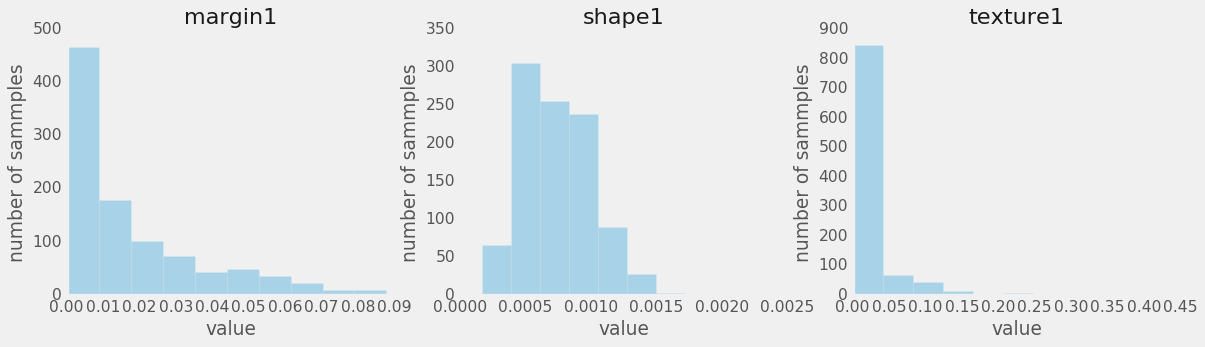

In [36]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.grid(False)
plt.title("margin1"); plt.xlabel("value"); plt.ylabel("number of sammples")
plt.hist(dfX['margin1'], alpha=0.3)

plt.subplot(1, 3, 2)
plt.grid(False)
plt.title("shape1"); plt.xlabel("value"); plt.ylabel("number of sammples")
plt.hist(dfX['shape1'], alpha=0.3)

plt.subplot(1, 3, 3)
plt.grid(False)
plt.title("texture1"); plt.xlabel("value"); plt.ylabel("number of sammples")
plt.hist(dfX['texture1'], alpha=0.3)

plt.show()

> ** #dfX shape 변수 간 높은 상관관계를 보임, 추후 df에 PCA 처리 고려 **

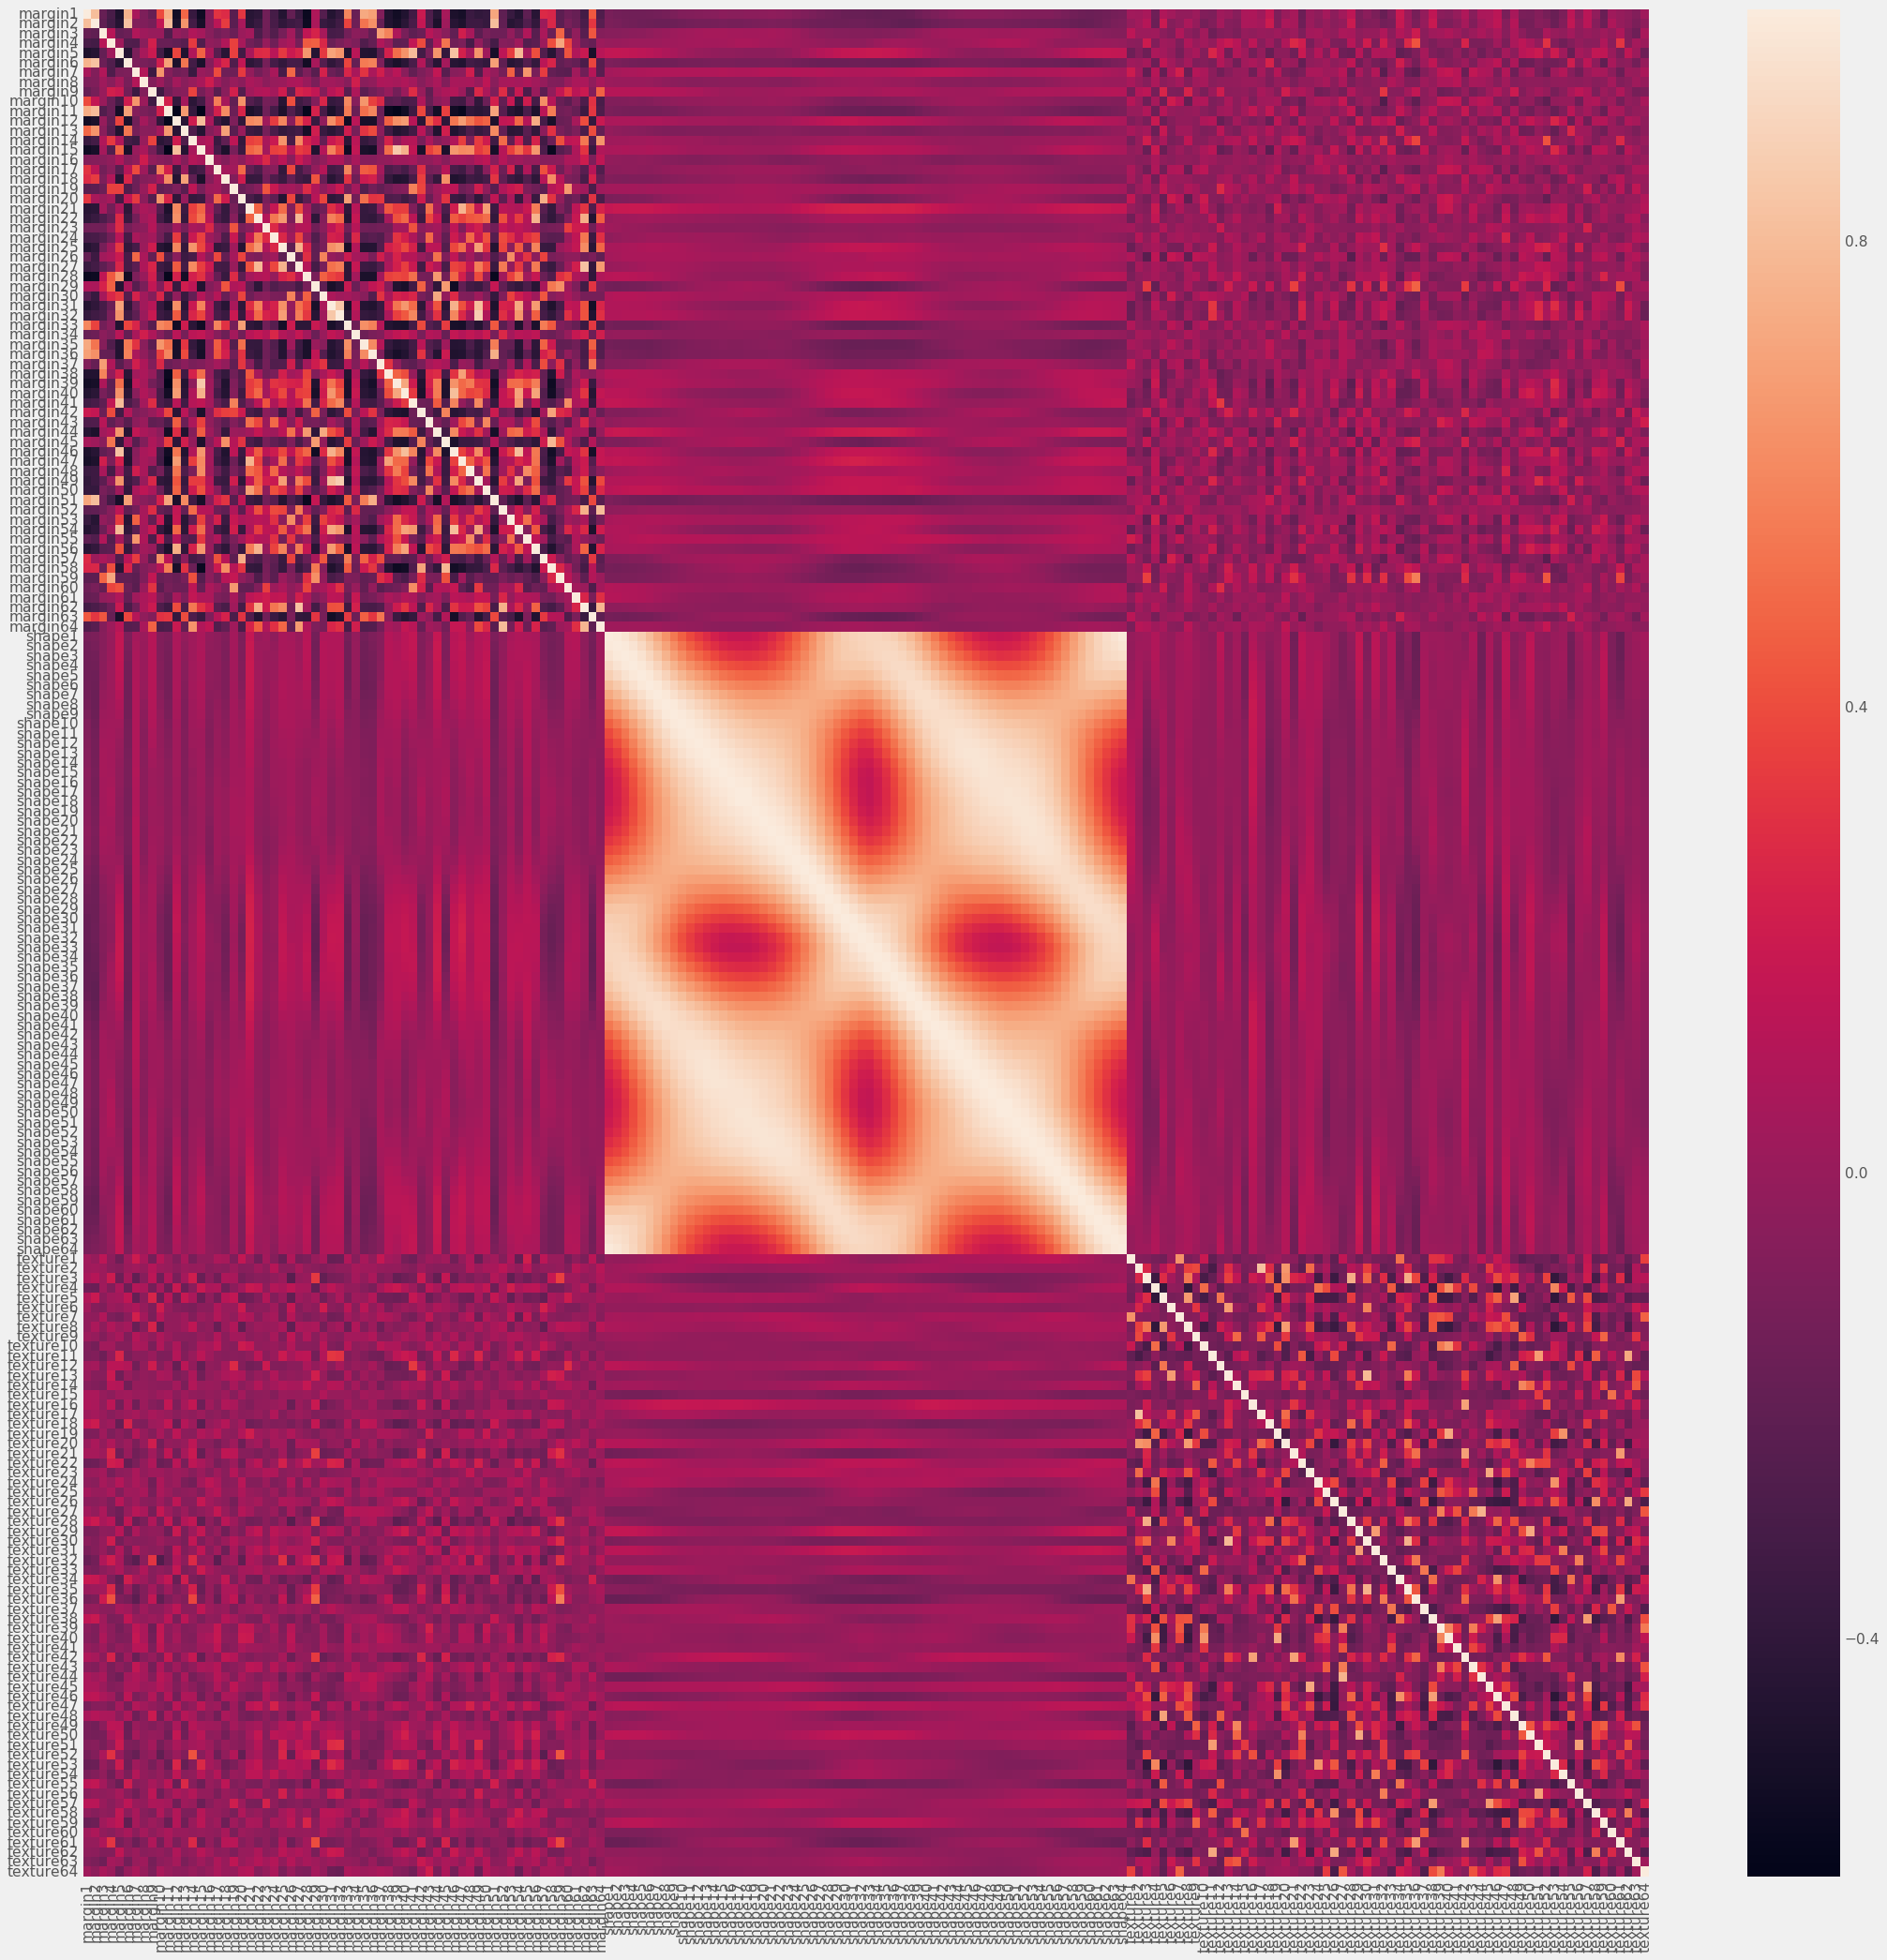

In [40]:
plt.figure(figsize=(30, 30))
corr = dfX.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

> ** #dfy 99종, 각 10개 샘플 **

In [92]:
dfy_class_counting = train_df.groupby('species')['species'].count().copy()
print("All classes have {} samples".format(dfy_class_counting.unique()))
print('-'*120)
print("Class name is ")
print()
for i in range(99):
    if (i % 4 == 0) and (i != 0):
        print()
    print('{:30}  '.format(dfy_class_counting.index[i]), end="")
    

All classes have [10] samples
------------------------------------------------------------------------------------------------------------------------
Class name is 

Acer_Capillipes                 Acer_Circinatum                 Acer_Mono                       Acer_Opalus                     
Acer_Palmatum                   Acer_Pictum                     Acer_Platanoids                 Acer_Rubrum                     
Acer_Rufinerve                  Acer_Saccharinum                Alnus_Cordata                   Alnus_Maximowiczii              
Alnus_Rubra                     Alnus_Sieboldiana               Alnus_Viridis                   Arundinaria_Simonii             
Betula_Austrosinensis           Betula_Pendula                  Callicarpa_Bodinieri            Castanea_Sativa                 
Celtis_Koraiensis               Cercis_Siliquastrum             Cornus_Chinensis                Cornus_Controversa              
Cornus_Macrophylla              Cotinus_Coggygria          

### 1.1.2 image EDA & Preprocessing

> ** #img 이미지는 다른 픽셀을 가짐, 3차원으로 구성 **

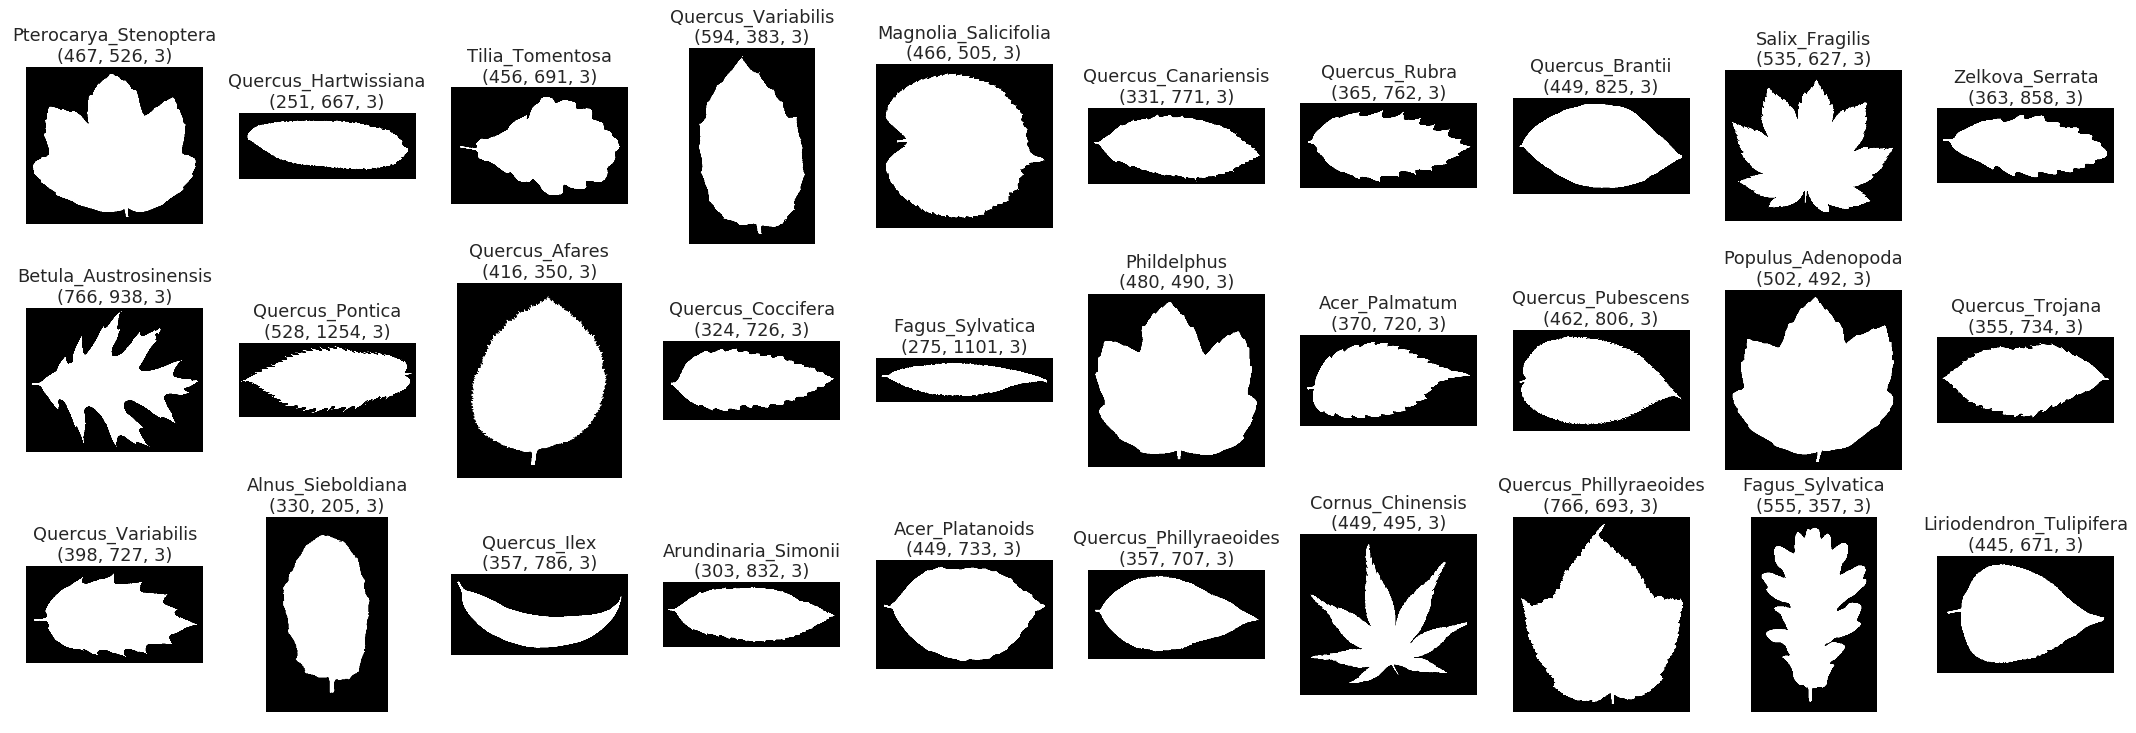

In [105]:
folder_addr = '../images'

plt.figure(figsize=(30, 10))
for row in range(3):
    for col in range(10):
        plt.subplot(3, 10, row*10+col+1)
        img = cv2.imread('{}/{}.jpg'.format(folder_addr, row*10+col+1))
        plt.title(train_df['species'][row*10+col+1] + "\n" \
                  + str(img.shape), fontsize=16)
        plt.axis("off")
        plt.imshow(img)

> ** #img 최대 픽셀은 Rows : 1089, Columns : 1706 으로 나타남, 추후 연산 상 오류가 발견됨 (최대 픽셀이 최소 300씩 더 큼) **

In [107]:
folder_addr = '../images'

# get rows, cols of original pictures
rows_list = []
cols_list = []
image_num = range(1, 1585)

for i in range(image_num):
    img = cv2.imread('{}/{}.jpg'.format(folder_addr, i))
    rows, cols, channels = img.shape
    rows_list.append(rows)
    cols_list.append(cols)
max_row = np.max(rows_list)
max_col = np.max(cols_list)
print("Check {} rows to find the maximum".format(len(rows_list)))
print("Check {} cols to find the maximum".format(len(cols_list)))
print("Maximum row pixel : ", str(max_row))
print("Maximum col pixel : ", str(max_col))

Check 1584 rows to find the maximum
Check 1584 cols to find the maximum
Maximum row pixel :  1089
Maximum col pixel :  1706


> ** #img train, test 이미지 전처리(RGB 평균값, 바이널라이즈, 최대 픽셀에 맞춰 크기 조정, 이미지 위치 조정-가운데) **

In [ ]:
folder_addr = '../images'
folder_addr_write = '../images_preprocessed_20171113'

default_xc = max_row + 301; default_yc = max_col + 300
image_num = range(1, 1585)

for i in range(image_num):
    img = cv2.imread('{}/{}.jpg'.format(folder_addr, i))
    
    # get avg
    img_mean = np.sum(img, axis=2)/3
    
    # binary preprocessing
    img_mean[img_mean<127] = 0
    img_mean[img_mean>=127] = 255
    
    # make new default array and override the target img on the center of default
    temp = np.zeros([default_xc, default_yc])
    xc, yc = ndi.center_of_mass(img_mean)
    left_x = default_xc/2 - xc; bottom_y = default_yc/2 - yc
    trans_x_coord = [int(round(left_x)), int(round(left_x)) + img_mean.shape[0]]
    trans_y_coord = [int(round(bottom_y)), int(round(bottom_y)) + img_mean.shape[1]]
    temp[trans_x_coord[0]:trans_x_coord[1], trans_y_coord[0]:trans_y_coord[1]] = img_mean
    cv2.imwrite('{}/{}.jpg'.format(folder_addr_write, i), temp)

In [149]:
folder_addr = '../images_preprocessed_20171113'
img = cv2.imread('{}/{}.jpg'.format(folder_addr, 1))
print("Binary preprocessing result shows ", np.unique(img[:, :, 0]))
print("Processed image's shape : ", img.shape)

Binary preprocessing result shows  [  0   1   2   3   4   5   6   7 248 249 250 251 252 253 254 255]
Processed image's shape :  (1390, 2006, 3)


> ** #img 전처리 후 이미지 확인, 카테고리별 **

In [21]:
# categorical grouping and listing id
g = train_df.groupby('species')['id'].apply(list)
g

species
Acer_Capillipes                 [201, 227, 498, 569, 610, 990, 1196, 1377, 152...
Acer_Circinatum                 [160, 164, 166, 235, 268, 496, 962, 1000, 1019...
Acer_Mono                       [216, 288, 489, 499, 807, 892, 1005, 1342, 151...
Acer_Opalus                     [1, 317, 906, 1002, 1125, 1159, 1270, 1320, 14...
Acer_Palmatum                   [27, 118, 203, 324, 960, 1041, 1085, 1088, 137...
Acer_Pictum                     [146, 311, 362, 810, 915, 949, 956, 1417, 1538...
Acer_Platanoids                 [38, 322, 331, 408, 511, 589, 754, 1011, 1467,...
Acer_Rubrum                     [238, 698, 727, 873, 1117, 1154, 1165, 1216, 1...
Acer_Rufinerve                  [148, 364, 404, 570, 641, 651, 652, 713, 853, ...
Acer_Saccharinum                [78, 167, 253, 365, 506, 763, 864, 1003, 1182,...
Alnus_Cordata                   [186, 198, 505, 629, 647, 839, 1235, 1242, 143...
Alnus_Maximowiczii              [140, 663, 805, 877, 893, 983, 1217, 1232, 128...
Alnus_Ru

> ** #img 모양과 방향은 비슷함, 같은 종인데 크기가 차이나는 경우가 있음 **

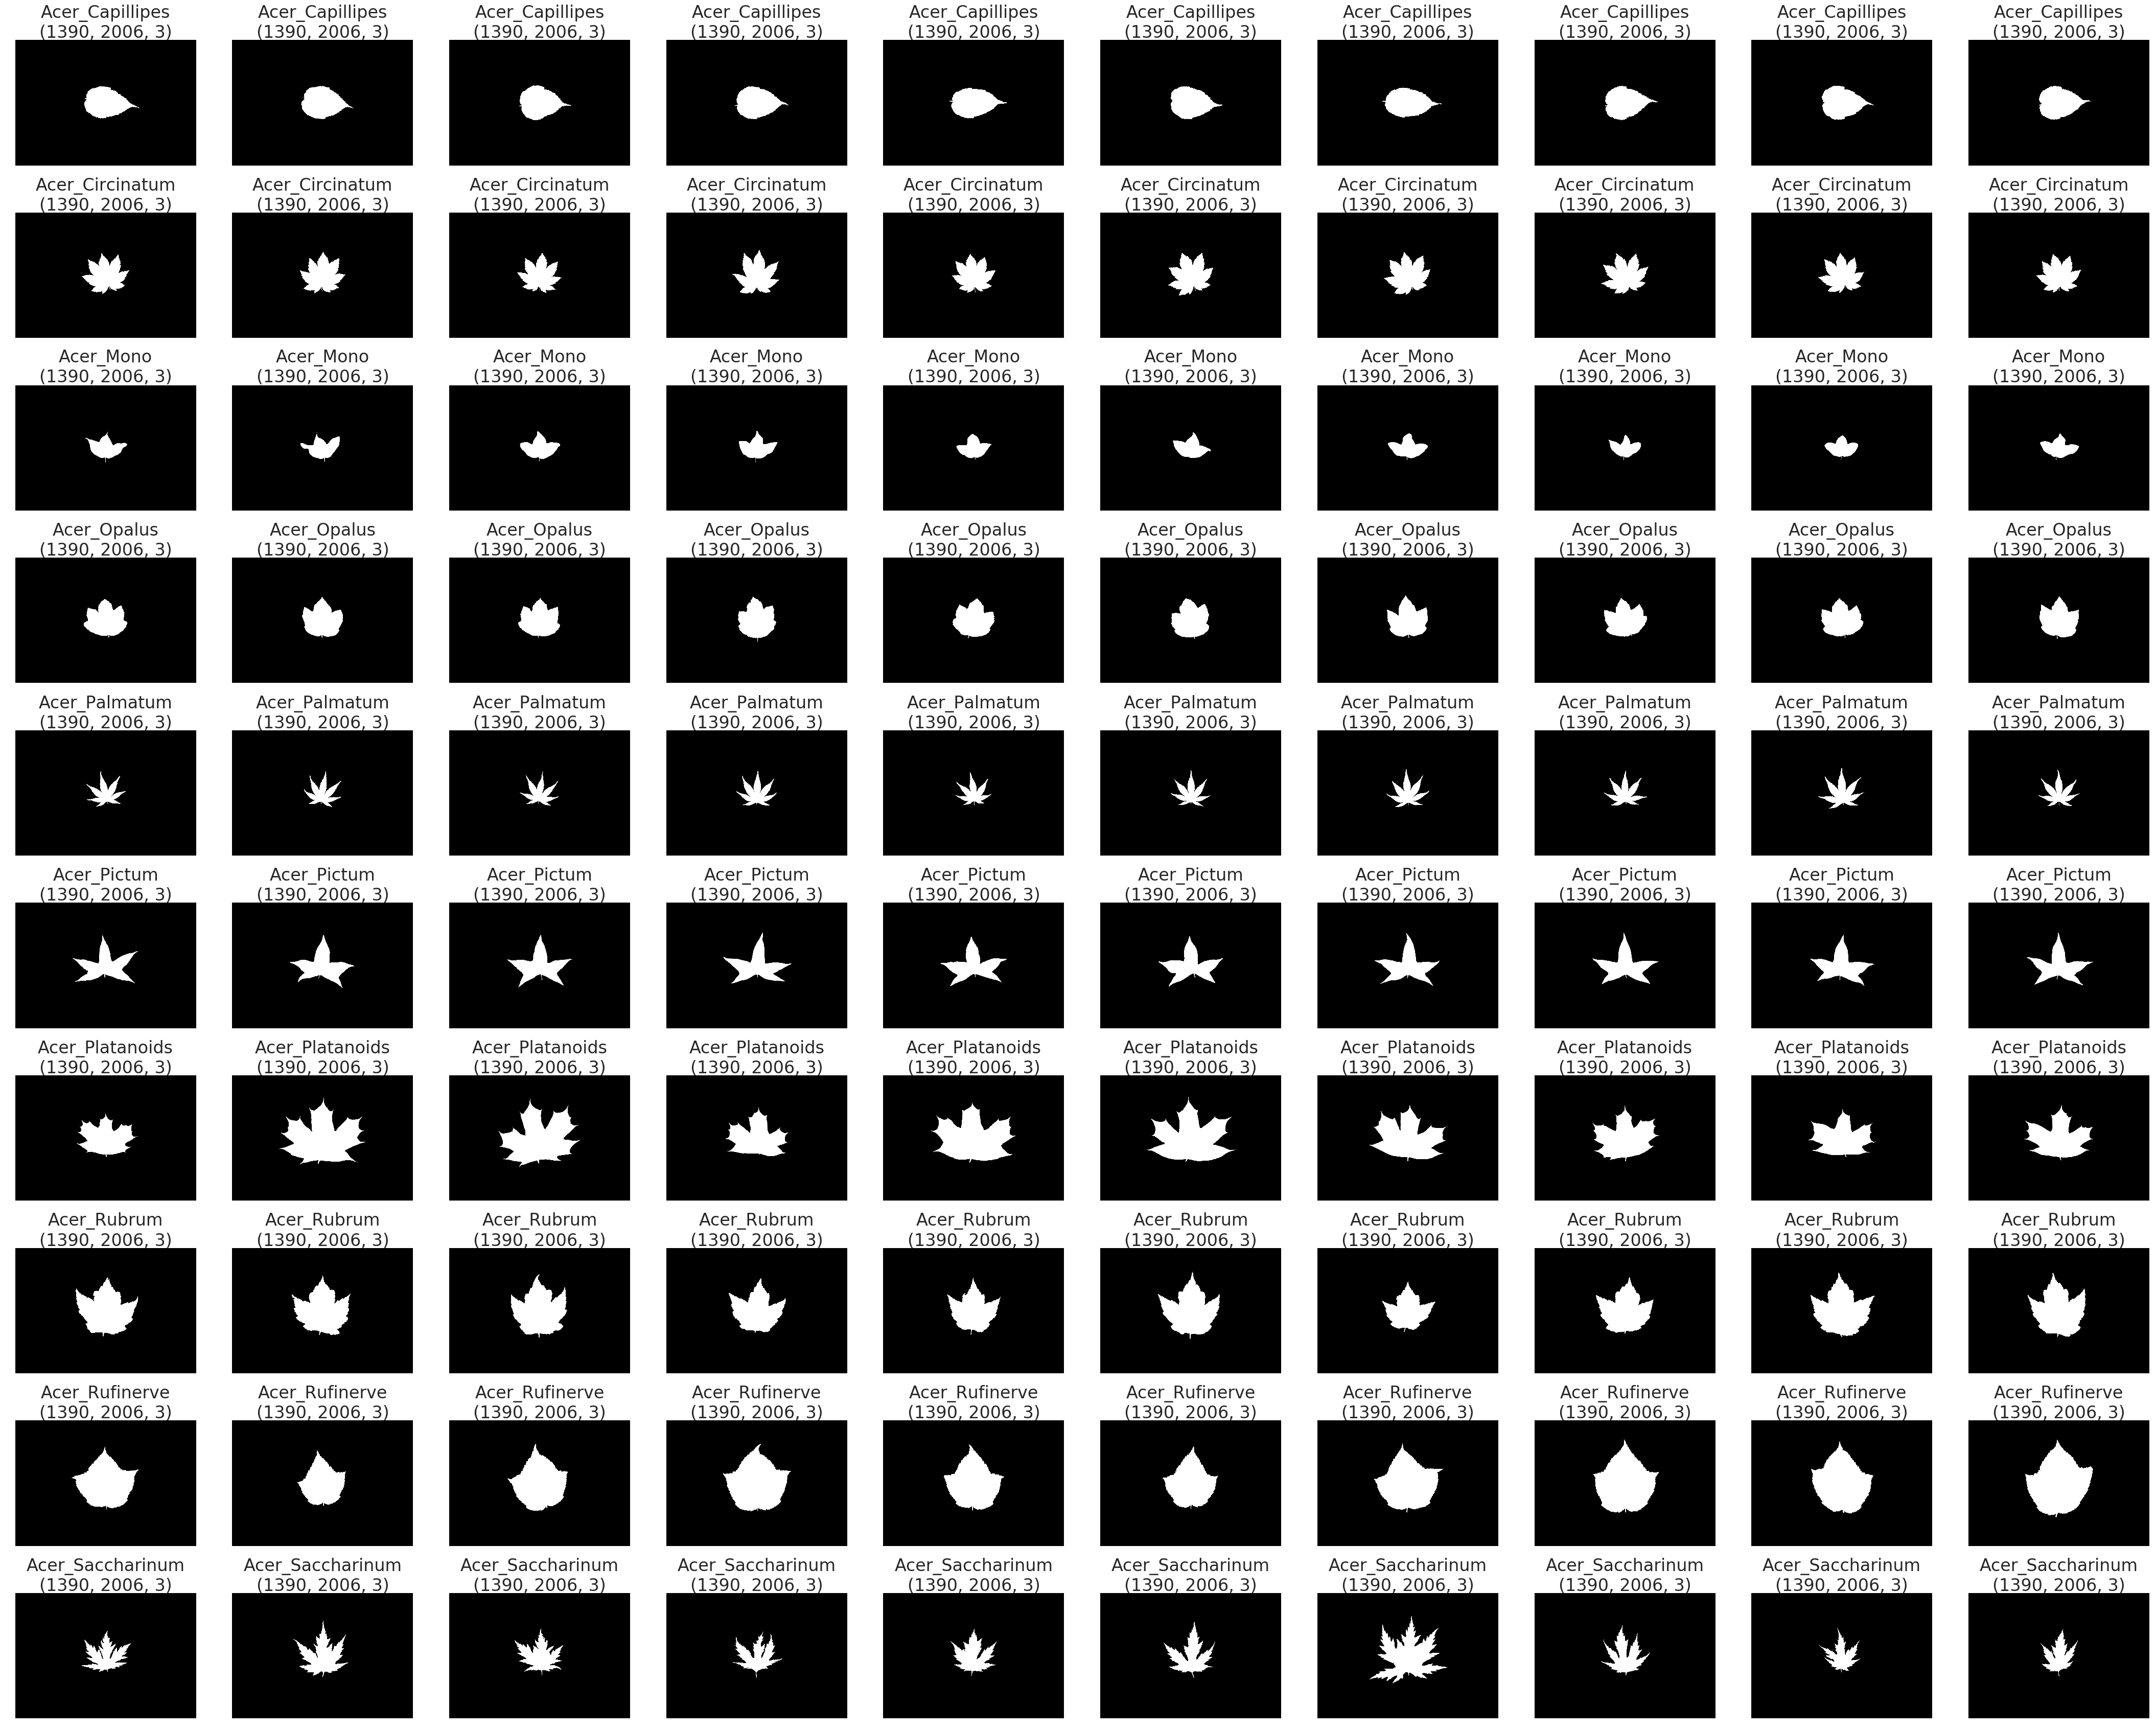

In [136]:
folder_addr = '../images_preprocessed_20171113'

index = 0
plt.figure(figsize=(60, 50))
for row in range(index*10, (index+1)*10):
    for col in range(10):
        plt.subplot(10, 10, (row-index*10)*10+col+1)
        img = cv2.imread('{}/{}.jpg'.format(folder_addr, g.values[row][col]))
        plt.title(g.index[row] + "\n" \
                  + str(img.shape), fontsize=30)
        plt.axis("off")
        plt.imshow(img)

## 1.2 Feature Extraction from img
- Size, Area Ratio
- Array to feature

### 1.2.1 Info extraction : Original Pixel Rows, Cols

> ** #img 각 이미지의 픽셀 rows, cols를 데이터프레임화 하여 저장함 **

In [110]:
# get rows, cols of original pictures
rows_list = []
cols_list = []

for i in range(1, 1585):
    img = cv2.imread('../images/{}.jpg'.format(i))
    rows, cols, channels = img.shape
    rows_list.append(rows)
    cols_list.append(cols)
    
pixel_df = pd.DataFrame({'ori_rows' : rows_list, 'ori_cols': cols_list})
print(pixel_df.shape)
# pixel_df.to_csv('../pixel_rows_cols_df_20171107.csv', index=False)

(1584, 2)


> ** #img 종별 픽셀 rows, cols 평균 **

In [ ]:
temp_for_pixelcheck_df = pd.concat([dfX_std_scaled_3area_rc, train_df['species']], axis=1)
temp_for_pixelcheck_df[['species', 'ori_rows', 'ori_cols']].groupby('species').aggregate(np.average)

> ** #img 종별 픽셀 rows, cols std, 추후 변수 추가 고려 **

In [ ]:
temp_for_pixelcheck_df[['species', 'ori_rows', 'ori_cols']].groupby('species').aggregate(np.std)

### 1.2.1 Info extraction : Area Ratio

> ** #img contour, hull, rect, bound rect의 크기를 구함 **

Image shape is        :  (1390, 2006, 3)
Contour Area size     :  130411.0
Hull Area size        :  148377.5
Rectangular Area size :  204309
Bound Rect Area size  :  186613.265857


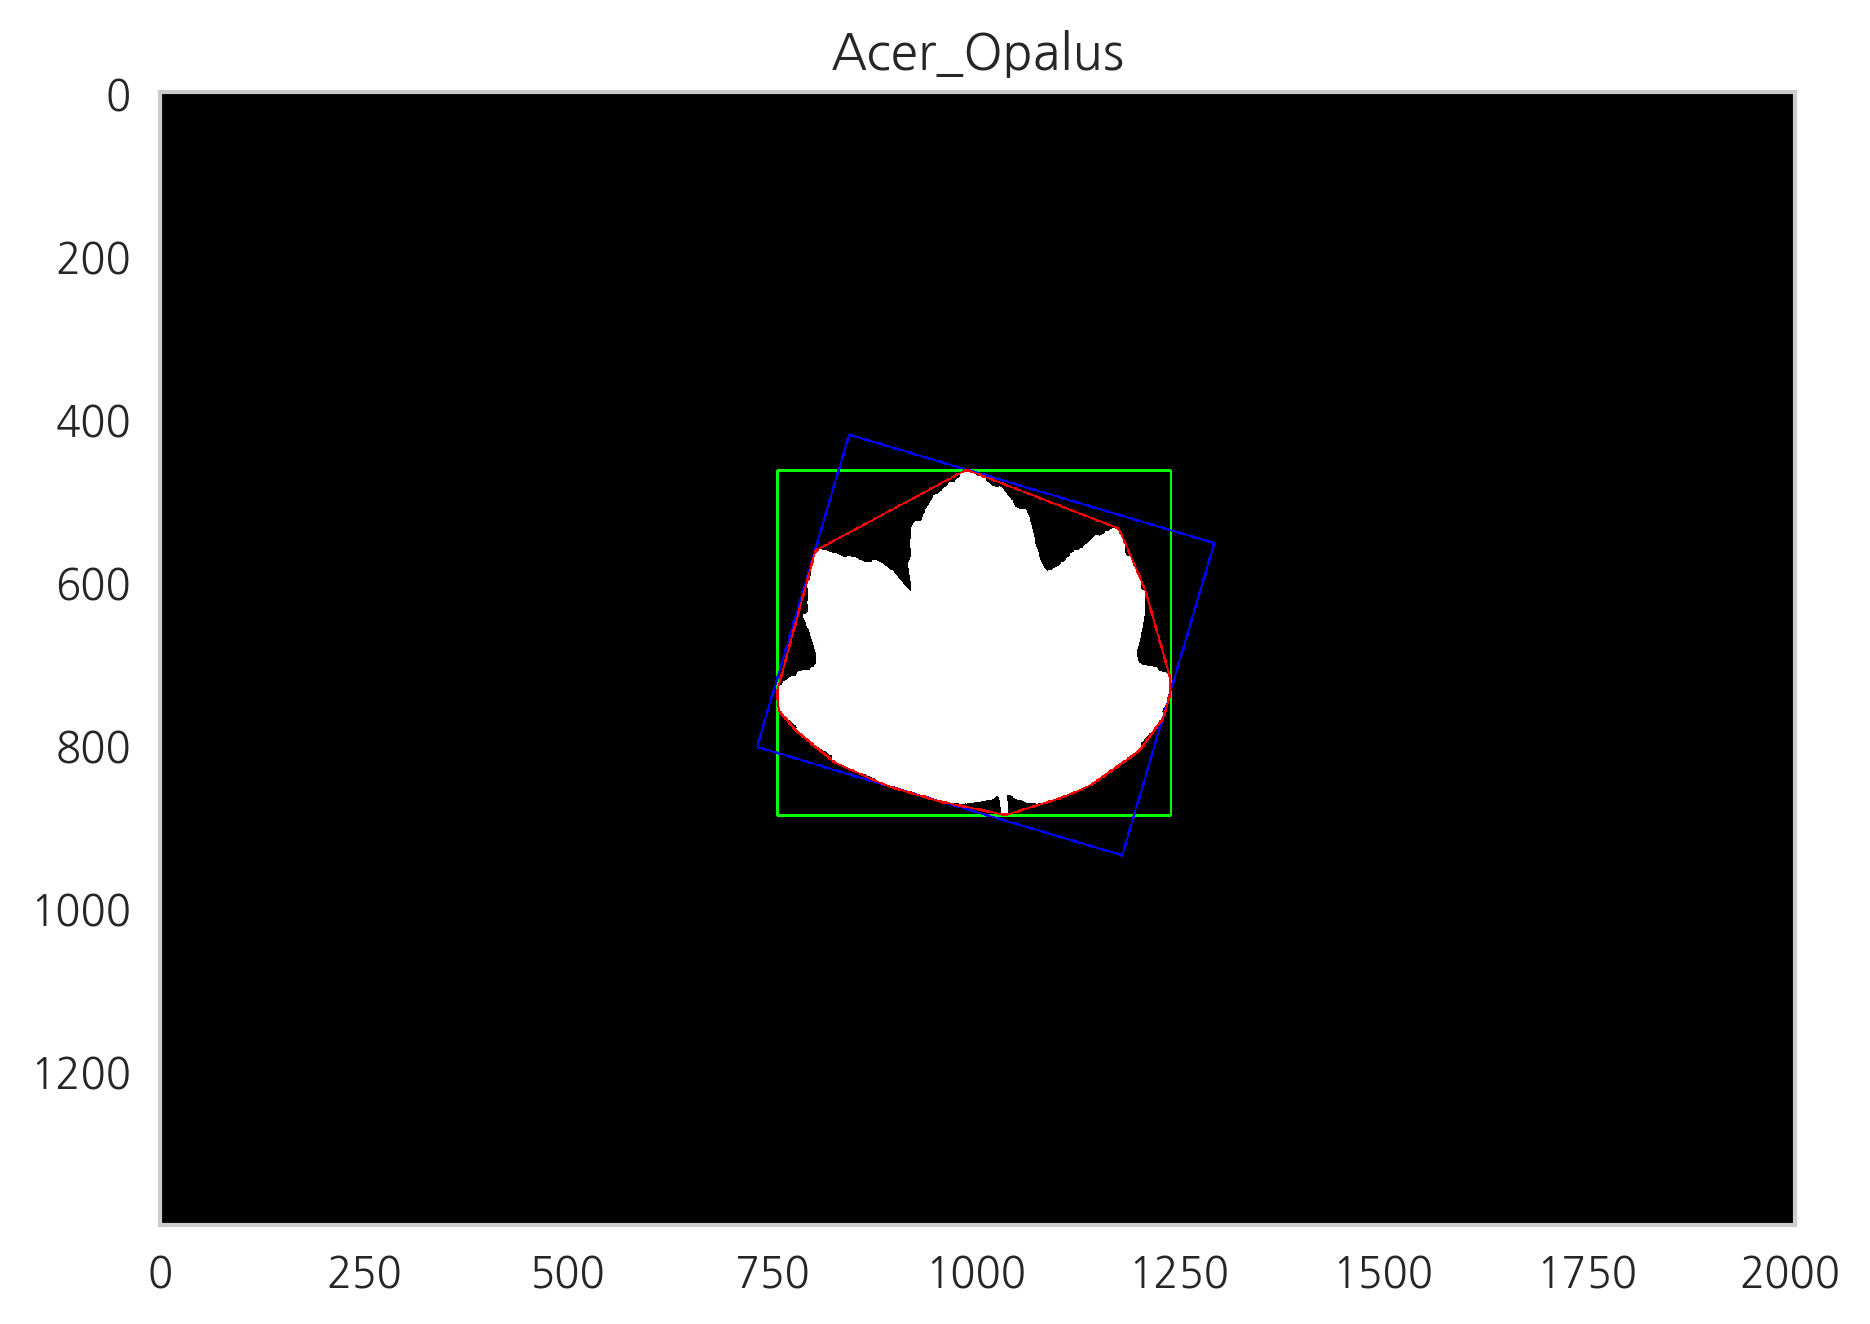

In [12]:
# reference : https://docs.opencv.org/trunk/d9/d8b/tutorial_py_contours_hierarchy.html
# reference : https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
# reference : https://github.com/abidrahmank/OpenCV2-Python/blob/master/Official_Tutorial_Python_Codes/3_imgproc/convexhull.py#L38
folder_addr = '../images_preprocessed_20171113'

def draw_area_line(_id, folder_addr, info_printing=0):
    img = cv2.imread('{}/{}.jpg'.format(folder_addr, _id))
    
    # reduction of dimension (1390, 2006, 3) -> (1390, 2006)
    imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # binarize by threshold, guess the array value changed when it is saved
    ret,thresh = cv2.threshold(imgray,127,255,0)   # unique value are only [0 255]
    
    # find contours and points of area
    image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)    
    cnt = contours[0]    
    hull = cv2.convexHull(cnt)
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    x,y,w,h = cv2.boundingRect(cnt)
    
    # area or distance calculation
    area = cv2.contourArea(cnt)
    hull_area = cv2.contourArea(hull)    
    dst1 = distance.euclidean(box[0],box[1])
    dst2 = distance.euclidean(box[1],box[2])
    
    # drawing part
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.drawContours(img,[box],0,(0,0,255),2)
    cv2.drawContours(img,[hull],0,(255,0,0),2)
    
    if info_printing != 0:
        print("Image shape is        : ", img.shape)
        print("Contour Area size     : ", area)
        print("Hull Area size        : ", hull_area)
        print("Rectangular Area size : ", w*h)
        print("Bound Rect Area size  : ", dst1 * dst2)
    try:
        plt.title(train_df.loc[train_df['id'] == _id, 'species'].values[0])
    except:
        raise ValueError("Please check your input '_id' is in the train_df")
    plt.grid(False)
    plt.imshow(img)

    
draw_area_line(1, folder_addr, 1)

> ** #img 일부 안그려지는 것도 있으나 대부분 정확하게 구해짐, 체크필요 **

In [20]:
folder_addr = '../images_preprocessed_20171113'

plt.figure(figsize=(30, 40))
rows = 4; cols = 3
for row in range(rows):
    for col in range(cols):
        plt.subplot(rows, cols, row*cols+col+1)
        draw_area_line(train_df['id'][row*cols+col+1], folder_addr, 0)
        plt.axis("off")

> ** #img 이미지 길이 또는 넓이 비율을 데이터프레임화함 **
- aspect_ratio = width / height
- extent = object_area / rectangle_area
- solidity = object_area / hull_area

In [70]:
width_list = []
height_list = []
object_area_list = []
rectangle_area_list = []
hull_area_list = []
file_addr = '../images_preprocessed_20171113'

for i in range(1, 1585):
    img = cv2.imread(file_addr + '/{}.jpg'.format(i))
    imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    
    x,y,w,h = cv2.boundingRect(cnt)
    hull = cv2.convexHull(cnt)
    
    if w > 1.2 * h:
        w, h = h, w
    
    object_area = cv2.contourArea(cnt)
    rectangle_area = w * h
    hull_area = cv2.contourArea(hull)
    
    width_list.append(w)
    height_list.append(h)
    object_area_list.append(object_area)
    rectangle_area_list.append(rectangle_area)
    hull_area_list.append(hull_area)

In [71]:
wh_area_df = pd.DataFrame({'width':width_list, 'height':height_list, 'object_area': object_area_list, 
                           'rectangle_area':rectangle_area_list, 'hull_area': hull_area_list})
wh_area_df.shape

(1584, 5)

In [75]:
wh_area_df.describe()

,height,hull_area,object_area,rectangle_area,width
count,1584.000000,1584.000000,1584.000000,1.584000e+03,1584.000000
mean,647.034091,178852.404987,147212.794192,2.653396e+05,371.811237
std,255.950206,126528.544795,87713.515659,1.894057e+05,191.917367
min,1.000000,0.000000,0.000000,1.000000e+00,1.000000
25%,512.000000,117462.000000,103730.000000,1.679745e+05,264.000000
50%,633.500000,142230.500000,130478.000000,2.133925e+05,348.000000
75%,800.500000,225328.250000,190121.875000,3.363930e+05,454.250000
max,1647.000000,882573.000000,624960.500000,1.255900e+06,1202.000000


> ** #img error check **

In [85]:
target1_h = wh_area_df.loc[wh_area_df['height'] < 200, ['height']]
target1_ha = wh_area_df.loc[wh_area_df['hull_area'] < 5000, ['hull_area']]
target1_oa = wh_area_df.loc[wh_area_df['object_area'] < 4000, ['object_area']]
target1_ra = wh_area_df.loc[wh_area_df['rectangle_area'] < 6000, ['rectangle_area']]
target1_w = wh_area_df.loc[wh_area_df['width'] < 100, ['width']]
print(len(target1_h.index))
print(len(target1_ha.index))
print(len(target1_oa.index))
print(len(target1_ra.index))
print(len(target1_w.index))

79
79
79
79
80


In [86]:
width_list = []
height_list = []
object_area_list = []
rectangle_area_list = []
hull_area_list = []
file_addr = '../images_preprocessed_20171113'

for i in target1_h.index:
    img = cv2.imread(file_addr + '/{}.jpg'.format(i))
    imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    
    x,y,w,h = cv2.boundingRect(cnt)
    hull = cv2.convexHull(cnt)
    
    if w > 1.2 * h:
        w, h = h, w
    
    object_area = cv2.contourArea(cnt)
    rectangle_area = w * h
    hull_area = cv2.contourArea(hull)
    
    width_list.append(w)
    height_list.append(h)
    object_area_list.append(object_area)
    rectangle_area_list.append(rectangle_area)
    hull_area_list.append(hull_area)

In [87]:
wh_area_df2 = pd.DataFrame({'width':width_list, 'height':height_list, 'object_area': object_area_list, 
                           'rectangle_area':rectangle_area_list, 'hull_area': hull_area_list}, index=target.index)
wh_area_df2.head(n=20)

,height,hull_area,object_area,rectangle_area,width
5,413,142267.5,130622.5,187502,454
23,730,146374.0,83817.0,213160,292
31,642,140017.5,130630.0,207366,323
35,453,60887.0,58410.0,91959,203
99,626,214465.0,199474.0,310496,496
107,626,244967.5,220671.5,348056,556
119,834,140368.5,130404.5,210168,252
132,906,132309.0,130066.5,194790,215
153,591,141756.5,130481.5,199758,338
170,783,132042.5,130298.5,185571,237


In [88]:
wh_area_df3 = wh_area_df2.combine_first(wh_area_df)
wh_area_df3.tail(n=30)

,height,hull_area,object_area,rectangle_area,width
1554,828.0,291198.5,164199.5,524952.0,634.0
1555,436.0,75237.5,59329.5,127748.0,293.0
1556,543.0,119755.0,102404.0,184620.0,340.0
1557,510.0,136299.0,130345.0,192780.0,378.0
1558,1244.0,302211.0,257512.5,518748.0,417.0
1559,736.0,170124.0,164288.0,268640.0,365.0
1560,808.0,137177.0,134652.0,206848.0,256.0
1561,574.0,140495.5,130406.5,215824.0,376.0
1562,454.0,85616.5,65143.0,131660.0,290.0
1563,325.0,50670.5,48542.5,68900.0,212.0


> ** #img 2번 구해도 처리되지 않는 4개가 남음 **

In [92]:
target2_h = wh_area_df3.loc[wh_area_df3['height'] < 100, 'height']
target2_ha = wh_area_df3.loc[wh_area_df3['hull_area'] < 5000, ['hull_area']]
target2_oa = wh_area_df3.loc[wh_area_df3['object_area'] < 4000, ['object_area']]
target2_ra = wh_area_df3.loc[wh_area_df3['rectangle_area'] < 6000, ['rectangle_area']]
target2_w = wh_area_df3.loc[wh_area_df3['width'] < 90, ['width']]
print(len(target2_h.index))
print(len(target2_ha))
print(len(target2_w))

4
4
4


In [97]:
fill_area_by_species = pd.concat([wh_area_df3, dfy], axis=1)
fill_area_by_species.iloc[[594, 835, 955, 988], :]

,height,hull_area,object_area,rectangle_area,width,species
594,4.0,0.0,0.0,4.0,1.0,57.0
835,1.0,0.0,0.0,1.0,1.0,7.0
955,1.0,0.0,0.0,1.0,1.0,14.0
988,4.0,0.0,0.0,4.0,1.0,80.0


In [94]:
fill_area_by_species.loc[fill_area_by_species['species'] == 53.0, :]

,height,hull_area,object_area,rectangle_area,width,species
27,705.0,302167.5,258359.5,446265.0,633.0,53.0
271,699.0,291755.5,245038.0,434079.0,621.0,53.0
313,748.0,217211.5,203164.5,330616.0,442.0,53.0
403,744.0,318538.0,268004.0,500712.0,673.0,53.0
449,643.0,117818.0,109799.5,182612.0,284.0,53.0
454,602.0,142608.0,130635.5,233576.0,388.0,53.0
492,728.0,246546.0,234837.5,363272.0,499.0,53.0
783,526.0,139014.5,130429.0,199880.0,380.0,53.0
878,589.0,89496.5,83407.5,127813.0,217.0,53.0
909,506.0,111434.0,105477.0,152812.0,302.0,53.0


In [95]:
fill_area_by_species.loc[fill_area_by_species['species'] == 53.0, :].groupby('species').aggregate(np.mean).values

array([[    649.  ,  197658.95,  176915.2 ,  297163.7 ,     443.9 ]])

> ** #img 4개는 평균으로 채움 **

In [99]:
fill_area_by_species.iloc[594, :5] = fill_area_by_species.loc[fill_area_by_species['species'] == 53.0, :]\
                                    .groupby('species').aggregate(np.mean).values
fill_area_by_species.iloc[835, :5] = fill_area_by_species.loc[fill_area_by_species['species'] == 64.0, :]\
                                    .groupby('species').aggregate(np.mean).values
fill_area_by_species.iloc[955, :5] = fill_area_by_species.loc[fill_area_by_species['species'] == 17.0, :]\
                                    .groupby('species').aggregate(np.mean).values
fill_area_by_species.iloc[988, :5] = fill_area_by_species.loc[fill_area_by_species['species'] == 69.0, :]\
                                    .groupby('species').aggregate(np.mean).values


In [102]:
fill_area_by_species.loc[fill_area_by_species.height < 100, :]

,height,hull_area,object_area,rectangle_area,width,species


In [103]:
fill_area_by_species.loc[fill_area_by_species.object_area < 4000, :]

,height,hull_area,object_area,rectangle_area,width,species


In [107]:
fill_area_by_species_final = fill_area_by_species.drop(['species'], axis=1).copy()

In [ ]:
# fill_area_by_species_final.to_csv('../wh_area_df_20171113.csv', index=False)

> ** #img 3가지 비율 팩터 데이터저장 **

In [108]:
fill_area_by_species_final['aspect_ratio'] = fill_area_by_species_final.width / fill_area_by_species_final.height
fill_area_by_species_final['extent'] = fill_area_by_species_final.object_area / fill_area_by_species_final.rectangle_area
fill_area_by_species_final['solidity'] = fill_area_by_species_final.object_area / fill_area_by_species_final.hull_area

In [ ]:
# fill_area_by_sepcies_final[['aspect_ratio', 'extent', 'solidity']].to_csv('../3area_factors_20171113.csv', index=False)

### 1.2.2 PCA

In [17]:
file_addr = '../images_preprocessed_20171113'

img = cv2.imread(file_addr + '/{}.jpg'.format(111))
print(np.unique(img))
img_re = rescale(img[:,:, 0], 0.04, mode='reflect')
print(np.unique(img_re))
img_re.shape

[  0   1   2   3   4   5   6   7 247 248 249 250 251 252 253 254 255]
[  0.00000000e+00   7.87815126e-06   8.27205882e-04   8.98109244e-04
   9.90021008e-04   1.93802521e-03   2.24264706e-03   2.30392157e-03
   2.35469188e-03   2.40546218e-03   2.45098039e-03   2.60416667e-03
   2.88602941e-03   3.23879552e-03   3.24754902e-03   3.80427171e-03
   3.98897059e-03   4.74527311e-03   5.23897059e-03   8.44275210e-03
   8.69485294e-03   1.02232143e-02   1.92489496e-02   4.75446429e-02
   9.47531513e-02   1.59298845e-01   3.95041141e-01   5.48883929e-01
   6.52490371e-01   6.68883929e-01   7.20231092e-01   7.46503852e-01
   8.12500000e-01   9.32912290e-01   9.62500000e-01   9.83806898e-01
   9.89644608e-01   9.90156688e-01   9.91228992e-01   9.92769608e-01
   9.93147759e-01   9.94087010e-01   9.94148284e-01   9.95563725e-01
   9.95659139e-01   9.96145833e-01   9.96899510e-01   9.97337185e-01
   9.97371324e-01   9.97640931e-01   9.97918417e-01   9.98284314e-01
   9.98632703e-01   9.99074755e-0

(56, 80)

Rows x Cols :  4480
Rescaled image :  (4480,)


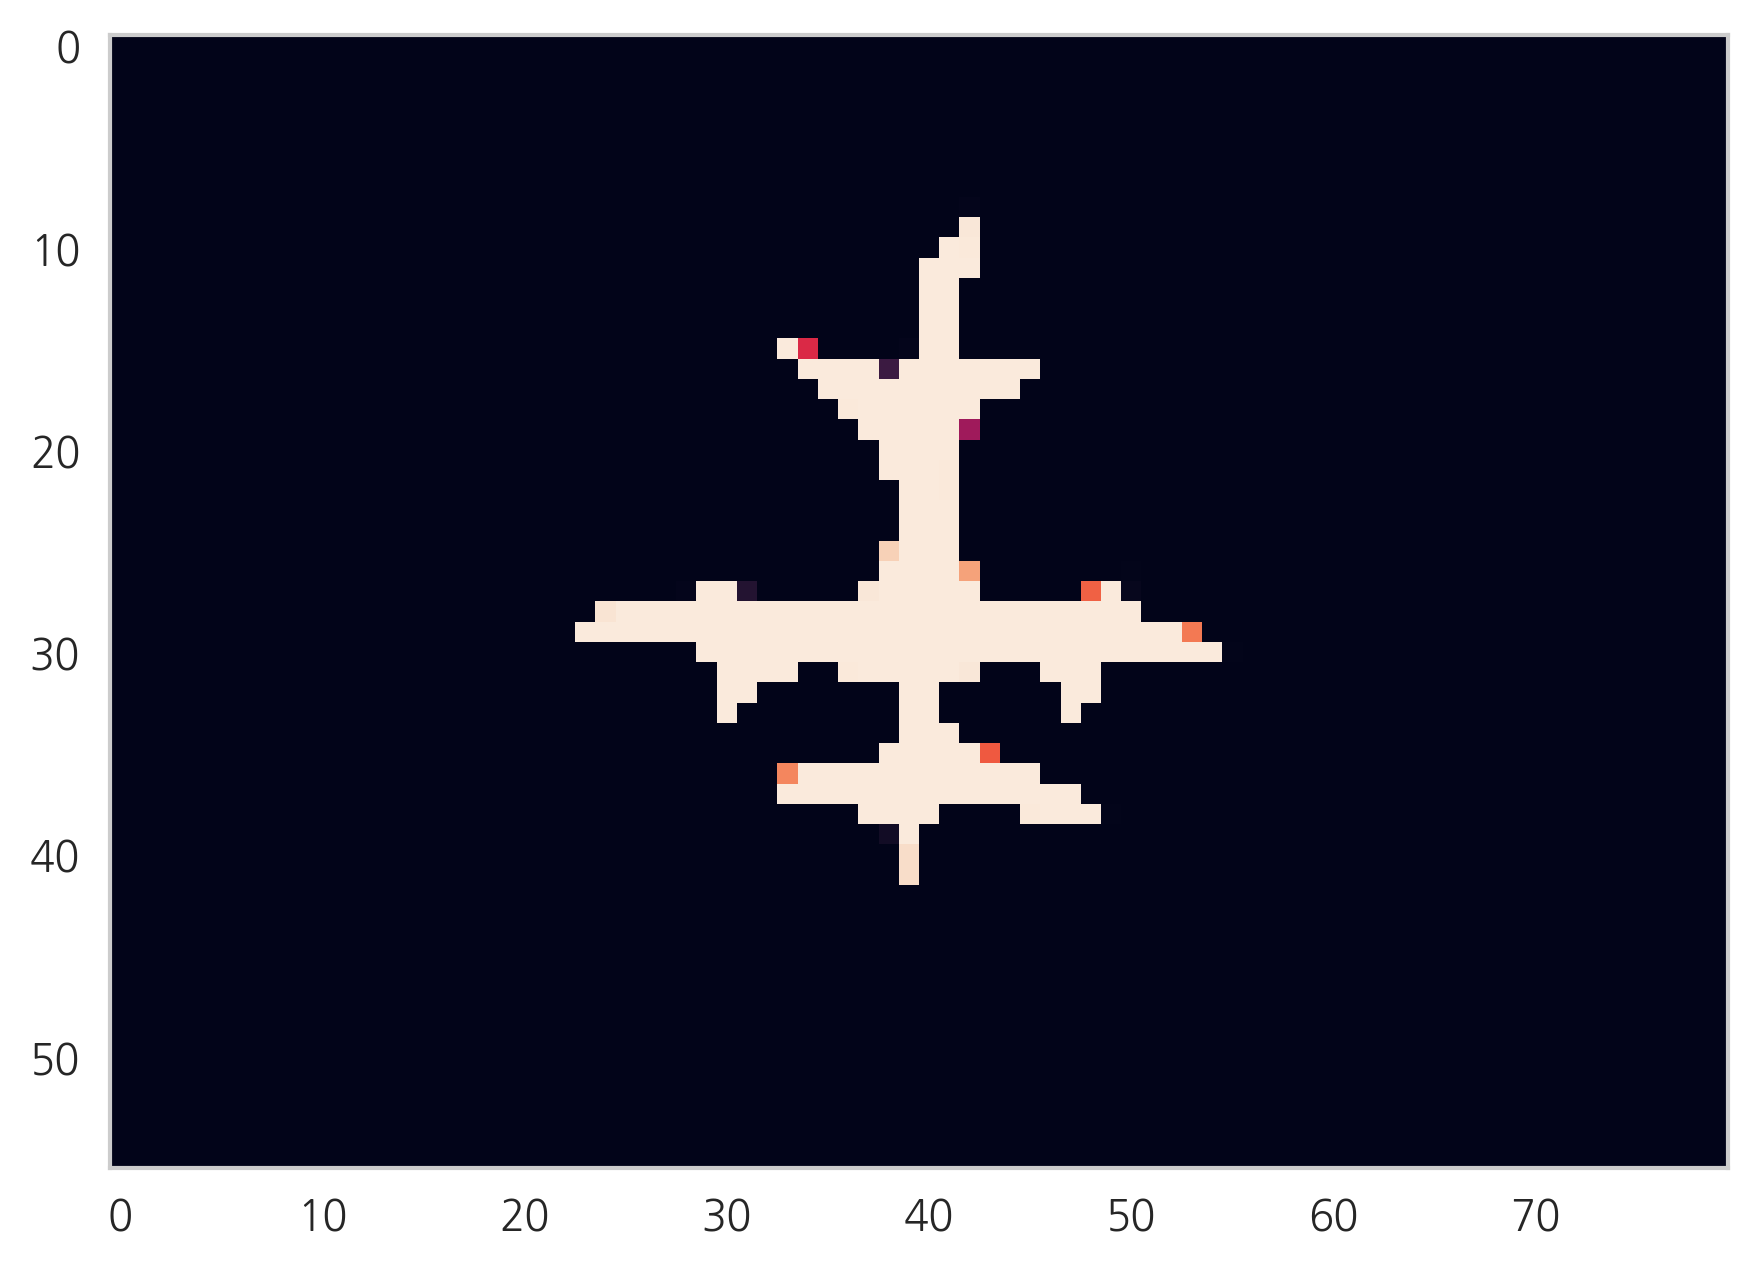

In [10]:
print("Rows x Cols : ", 56 * 80)
print("Rescaled image : ", img_re.flatten().shape)
plt.grid(False)
plt.imshow(img_re)

In [14]:
img_re[30]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.99791842,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        0.00398897,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [103]:
resc_img_list = []
file_addr = '../images_preprocessed_20171113'
for i in range(1, 1585):
    img = cv2.imread(file_addr + '/{}.jpg'.format(1))    
    img_re = rescale(img[:,:, 0], 0.04, mode='reflect')
    img_re[img_re < 0.5] = 0.01
    img_re[img_re >= 0.5] = 1
    resc_img_list.append(img_re.flatten())

> ** #img PCA 처리를 위해 남겨둠 **

In [104]:
np.unique(resc_img_list[0])

array([ 0.01,  1.  ])

In [105]:
resc_img_df = pd.DataFrame(np.array(resc_img_list))
resc_img_df.shape

(1584, 4480)

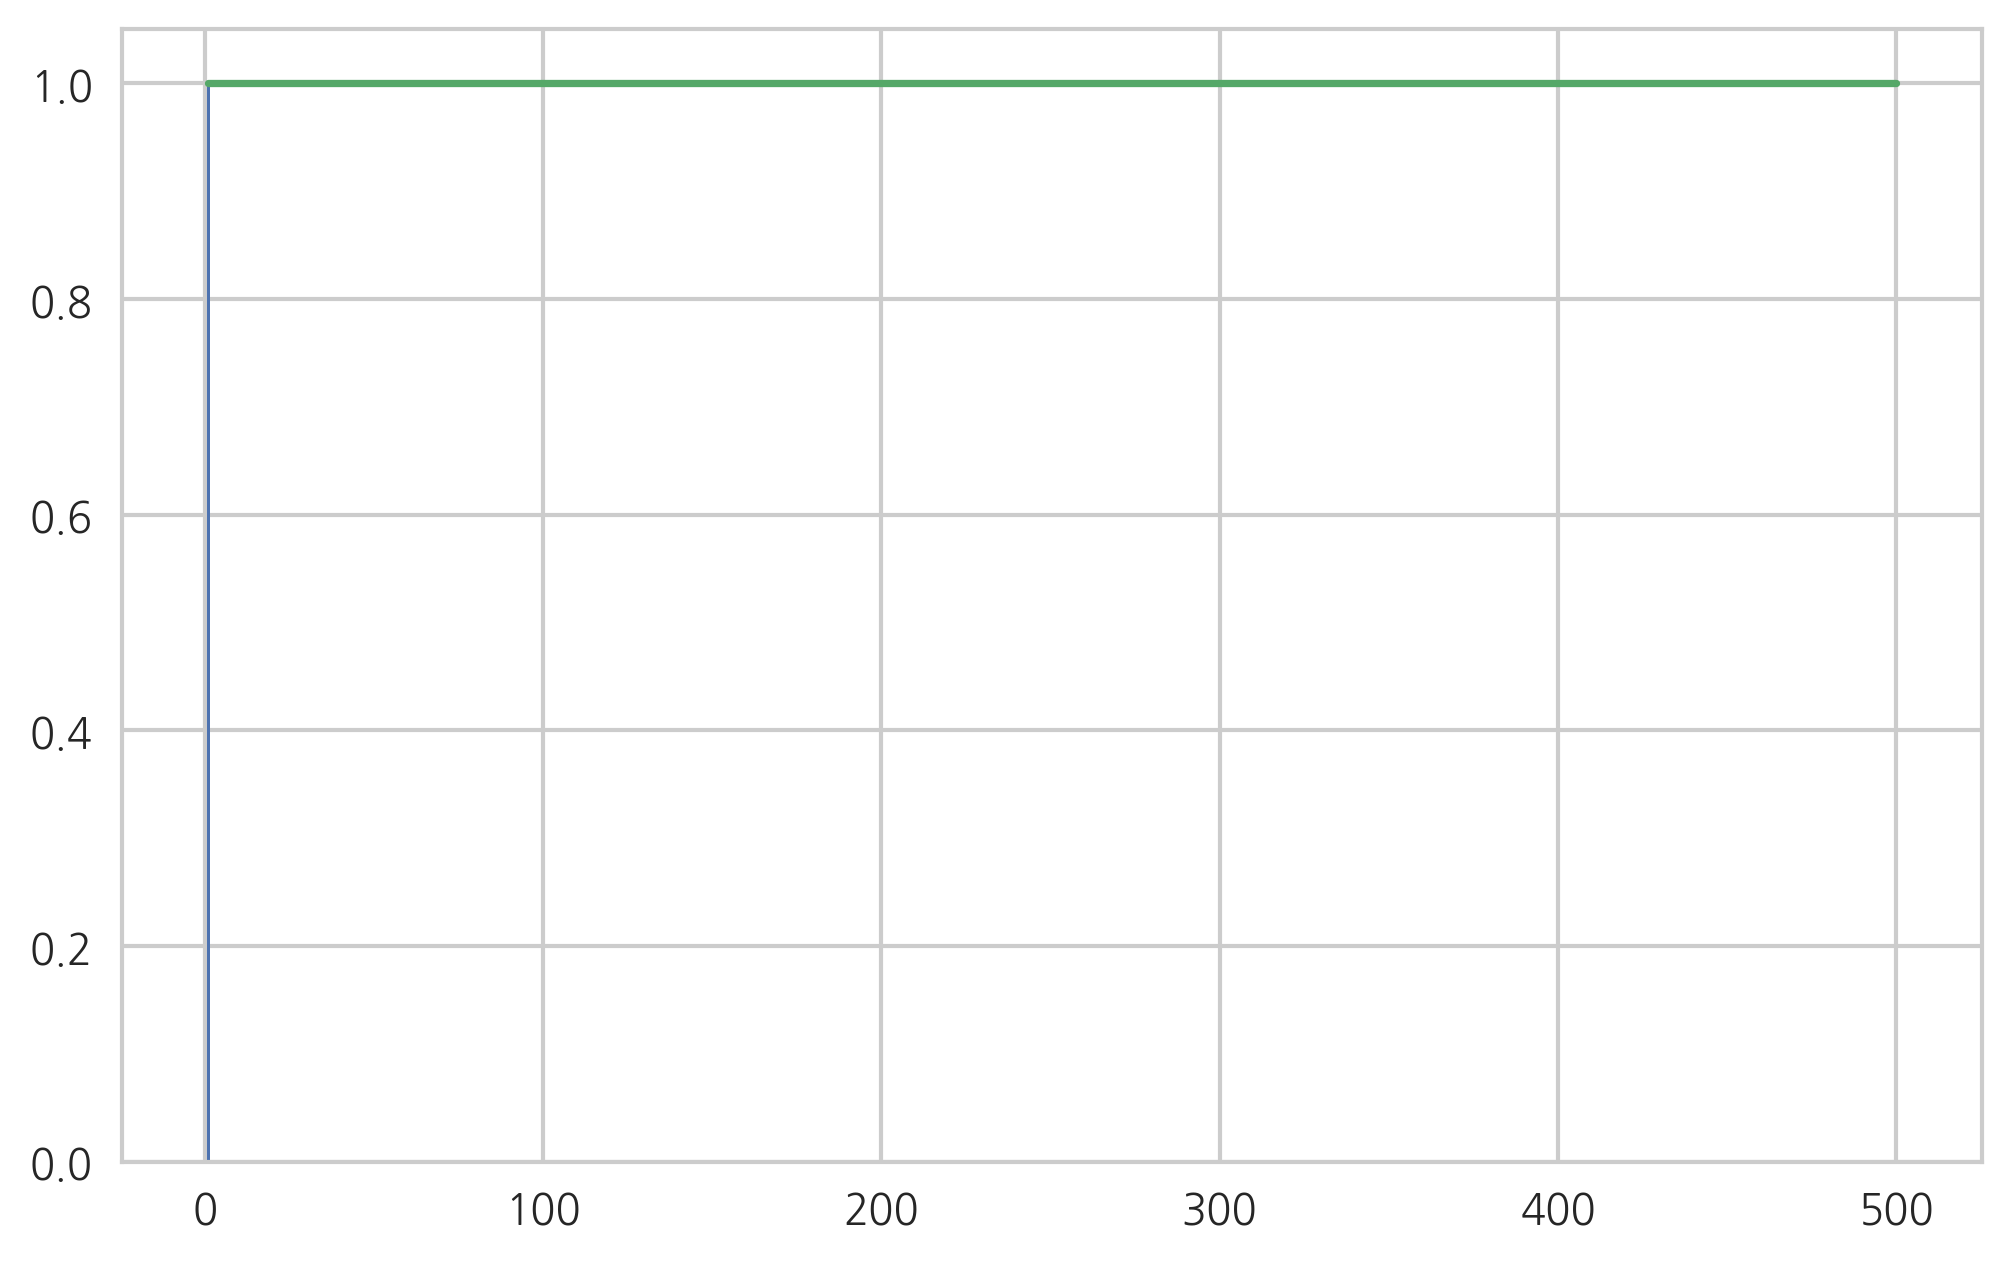

In [106]:
# reference : https://datascienceschool.net/view-notebook/f10aad8a34a4489697933f77c5d58e3a/

np.seterr(divide='ignore', invalid='ignore')
pca = PCA(500).fit(resc_img_df)
var = pca.explained_variance_
cmap = sns.color_palette()
plt.bar(np.arange(1,len(var)+1), var/np.sum(var), align="center", color=cmap[0])
plt.step(np.arange(1,len(var)+1), np.cumsum(var)/np.sum(var), where="mid", color=cmap[1])
plt.show()

In [107]:
pca1 = PCA(n_components=50).fit(resc_img_df)
Z_df = pd.DataFrame(pca1.transform(resc_img_df), columns=range(50))
Z_df.shape

(1584, 50)

In [108]:
Z_scaled_df = pd.DataFrame(StandardScaler().fit_transform(Z_df), columns=Z_df.columns)

In [111]:
# Z_df.to_csv('../pca_df.csv', index=False)

#  
#  * Pre-Modeling
#   

## Pre-Modeling 1 with Raw data (Multi-NB, Logistic Regression)

- **log loss** 
- Multi-NB : 4.20758632315
- LR : 4.07969868003

In [122]:
classes = range(len(dfy.unique()))

model1 = MultinomialNB().fit(dfX, dfy)
y1_pred = model1.predict(dfX)
model1_probs = model1.predict_proba(dfX)
score1 = log_loss(dfy, model1_probs)

model2 = LogisticRegression().fit(dfX, dfy)
y2_pred = model2.predict(dfX)
model2_probs = model2.predict_proba(dfX)
score2 = log_loss(dfy, model2_probs)

print(score1)
print(score2)

print(confusion_matrix(dfy, y1_pred))
print(classification_report(dfy, y1_pred))

print(confusion_matrix(dfy, y2_pred))
print(classification_report(dfy, y2_pred))

4.20758632315
4.07969868003
[[ 6  0  0 ...,  0  0  0]
 [ 0  8  0 ...,  0  0  0]
 [ 0  0  1 ...,  0  0  0]
 ..., 
 [ 0  0  0 ...,  0  0  2]
 [ 0  0  0 ...,  0  9  0]
 [ 0  0  0 ...,  0  0 10]]
             precision    recall  f1-score   support

          0       1.00      0.60      0.75        10
          1       1.00      0.80      0.89        10
          2       1.00      0.10      0.18        10
          3       1.00      1.00      1.00        10
          4       1.00      0.90      0.95        10
          5       0.77      1.00      0.87        10
          6       0.00      0.00      0.00        10
          7       0.83      1.00      0.91        10
          8       0.48      1.00      0.65        10
          9       0.53      1.00      0.69        10
         10       1.00      0.40      0.57        10
         11       0.67      0.60      0.63        10
         12       1.00      0.50      0.67        10
         13       0.90      0.90      0.90        10
         14 

/home/dockeruser/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Pre-Modeling 2 with scaled or standardized data 


- **logloss**
- Multi_NB with MinMax-Scaled : 0.41573029257
- Logistic with Std-Scaled : 0.547306380601

In [123]:
classes = range(len(dfy.unique()))

model1 = MultinomialNB().fit(dfX_minmax_scaled, dfy)
y1_pred = model1.predict(dfX_minmax_scaled)
model1_probs = model1.predict_proba(dfX_minmax_scaled)
score1 = log_loss(dfy, model1_probs)

model2 = LogisticRegression().fit(dfX_std_scaled, dfy)
y2_pred = model2.predict(dfX_std_scaled)
model2_probs = model2.predict_proba(dfX_std_scaled)
score2 = log_loss(dfy, model2_probs)

print(score1)
print(score2)

print(confusion_matrix(dfy, y1_pred))
print(classification_report(dfy, y1_pred))

print(confusion_matrix(dfy, y2_pred))
print(classification_report(dfy, y2_pred))

0.41573029257
0.547306384922
[[10  0  0 ...,  0  0  0]
 [ 0 10  0 ...,  0  0  0]
 [ 0  0 10 ...,  0  0  0]
 ..., 
 [ 0  0  0 ...,  8  0  0]
 [ 0  0  0 ...,  0 10  0]
 [ 0  0  0 ...,  0  0 10]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        10
          1       1.00      1.00      1.00        10
          2       1.00      1.00      1.00        10
          3       1.00      1.00      1.00        10
          4       1.00      1.00      1.00        10
          5       0.91      1.00      0.95        10
          6       1.00      0.80      0.89        10
          7       1.00      1.00      1.00        10
          8       1.00      1.00      1.00        10
          9       1.00      1.00      1.00        10
         10       1.00      1.00      1.00        10
         11       1.00      0.90      0.95        10
         12       0.77      1.00      0.87        10
         13       1.00      1.00      1.00        10
         14

> ** OVR Checking, 미처리시와 log loss 똑같음. 자동으로 처리되는 것으로 예상 **

In [125]:
model2 = OneVsRestClassifier(LogisticRegression()).fit(dfX_std_scaled, dfy)
y2_pred = model2.predict(dfX_std_scaled)
model2_probs = model2.predict_proba(dfX_std_scaled)
score2 = log_loss(dfy, model2_probs)

print(score2)
print(confusion_matrix(dfy, y2_pred))
print(classification_report(dfy, y2_pred))

0.547306259172
[[10  0  0 ...,  0  0  0]
 [ 0 10  0 ...,  0  0  0]
 [ 0  0 10 ...,  0  0  0]
 ..., 
 [ 0  0  0 ..., 10  0  0]
 [ 0  0  0 ...,  0 10  0]
 [ 0  0  0 ...,  0  0 10]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        10
          1       1.00      1.00      1.00        10
          2       1.00      1.00      1.00        10
          3       1.00      1.00      1.00        10
          4       1.00      1.00      1.00        10
          5       1.00      1.00      1.00        10
          6       1.00      1.00      1.00        10
          7       1.00      1.00      1.00        10
          8       1.00      1.00      1.00        10
          9       1.00      1.00      1.00        10
         10       1.00      1.00      1.00        10
         11       1.00      1.00      1.00        10
         12       1.00      1.00      1.00        10
         13       1.00      1.00      1.00        10
         14       1.00   

## Pre-Modeling 3 with Rows, Cols, Area Ratio added data

- ** Log Loss **
- Gaussian-NB : 0.0348876529243
- Logistic : 0.535036416899
> 가우시안의 과적합으로 예상됨

In [127]:
X_dataset = dfX_std_scaled_3area_rc
y_dataset = dfy

classes = range(len(y_dataset.unique()))

model1 =  GaussianNB().fit(X_dataset, y_dataset)
y1_pred = model1.predict(X_dataset)
model1_probs = model1.predict_proba(X_dataset)
score1 = log_loss(y_dataset, model1_probs)

model2 = LogisticRegression().fit(X_dataset, y_dataset)
y2_pred = model2.predict(X_dataset)
model2_probs = model2.predict_proba(X_dataset)
score2 = log_loss(y_dataset, model2_probs)

print(score1)
print(score2)

print(confusion_matrix(y_dataset, y1_pred))
print(classification_report(y_dataset, y1_pred))

print(confusion_matrix(y_dataset, y2_pred))
print(classification_report(y_dataset, y2_pred))

0.0348876529243
0.535036416899
[[10  0  0 ...,  0  0  0]
 [ 0 10  0 ...,  0  0  0]
 [ 0  0 10 ...,  0  0  0]
 ..., 
 [ 0  0  0 ..., 10  0  0]
 [ 0  0  0 ...,  0 10  0]
 [ 0  0  0 ...,  0  0 10]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        10
          1       1.00      1.00      1.00        10
          2       1.00      1.00      1.00        10
          3       1.00      1.00      1.00        10
          4       1.00      1.00      1.00        10
          5       1.00      1.00      1.00        10
          6       1.00      1.00      1.00        10
          7       1.00      1.00      1.00        10
          8       1.00      1.00      1.00        10
          9       1.00      1.00      1.00        10
         10       1.00      1.00      1.00        10
         11       1.00      1.00      1.00        10
         12       1.00      1.00      1.00        10
         13       1.00      1.00      1.00        10
         

In [138]:
X_dataset = dfX_std_scaled_3area_rc
y_dataset = dfy

cross_val_score(GaussianNB(), X_dataset, y_dataset, scoring='neg_log_loss', cv=5)

array([-13.43174638, -14.65295088, -17.09494993, -15.35056729, -16.39719687])

In [129]:
X_dataset = dfX_std_scaled_3area_rc
y_dataset = dfy

cross_val_score(LogisticRegression(), X_dataset, y_dataset, scoring='neg_log_loss', cv=5)

array([-0.85917893, -0.82163638, -0.86081568, -0.84336214, -0.85031487])

## Pre-Modeling 4 with QDA

In [139]:
X_dataset = dfX_std_scaled_3area
y_dataset = dfy

qda = QuadraticDiscriminantAnalysis().fit(X_dataset, y_dataset)
qda_pred_dfy = qda.predict(X_dataset)
qda_pred_proba_dfy = qda.predict_proba(X_dataset)
score2 = log_loss(dfy_onehot, qda_pred_proba_dfy)

print(score2)
print(confusion_matrix(y_dataset, qda_pred_dfy))
print(classification_report(y_dataset, qda_pred_dfy))

/home/dockeruser/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


1.03415592588e-13
[[10  0  0 ...,  0  0  0]
 [ 0 10  0 ...,  0  0  0]
 [ 0  0 10 ...,  0  0  0]
 ..., 
 [ 0  0  0 ..., 10  0  0]
 [ 0  0  0 ...,  0 10  0]
 [ 0  0  0 ...,  0  0 10]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        10
          1       1.00      1.00      1.00        10
          2       1.00      1.00      1.00        10
          3       1.00      1.00      1.00        10
          4       1.00      1.00      1.00        10
          5       1.00      1.00      1.00        10
          6       1.00      1.00      1.00        10
          7       1.00      1.00      1.00        10
          8       1.00      1.00      1.00        10
          9       1.00      1.00      1.00        10
         10       1.00      1.00      1.00        10
         11       1.00      1.00      1.00        10
         12       1.00      1.00      1.00        10
         13       1.00      1.00      1.00        10
         14       1.00

In [133]:
X_dataset = dfX_std_scaled_3area_rc
y_dataset = dfy

cross_val_score(QuadraticDiscriminantAnalysis(), X_dataset, y_dataset, scoring='neg_log_loss', cv=5)

/home/dockeruser/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/dockeruser/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/dockeruser/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/dockeruser/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/dockeruser/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


array([-33.49214681, -32.61995548, -33.49214681, -32.96883201, -33.14327028])